## Imports


Libraries

In [4]:
import cv2
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




Helper functions

In [5]:
import sys
sys.path.insert(0, 'D:/GrowTech/cropsimagesproject/src/helper_functions')

from count_folders import count_folders
no_of_classes = count_folders(r'D:\GrowTech\cropsimagesproject\data\raw\color')
no_of_classes


38

## Model


In [6]:
model = models.googlenet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, no_of_classes)  


# smoothed_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
# _, thresholded_image = cv2.threshold(smoothed_image, 127, 255, cv2.THRESH_BINARY)

# cv2.imshow('Preprocessed Image', preprocessed_image)


c:\Users\DELL\.conda\envs\growtech-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\.conda\envs\growtech-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available. Running on GPU.")
else:
    print("GPU is not available. Running on CPU.")

GPU is not available. Running on CPU.


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [9]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

data_dir = r'D:\GrowTech\cropsimagesproject\data\raw\color'  
dataset = ImageFolder(data_dir, transform=data_transforms)

batch_size = 32

train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

c:\Users\DELL\.conda\envs\growtech-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\.conda\envs\growtech-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\.conda\envs\growtech-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.19      0.32       132
           1       0.91      0.73      0.81       118
           2       0.00      0.00      0.00        59
           3       0.78      0.90      0.84       340
           4       0.90      0.91      0.90       309
           5       0.88      0.91      0.90       235
           6       0.97      0.80      0.87       178
           7       1.00      0.10      0.18       113
           8       0.92      0.99      0.95       252
           9       0.65      0.92      0.76       187
          10       0.96      1.00      0.98       236
          11       0.79      0.81      0.80       242
          12       0.82      0.93      0.87       281
          13       0.91      0.96      0.93       199
          14       1.00      0.18      0.30        74
          15       0.95      0.99      0.97      1072
          16       0.79      0.95      0.86       464
          17       1.00    

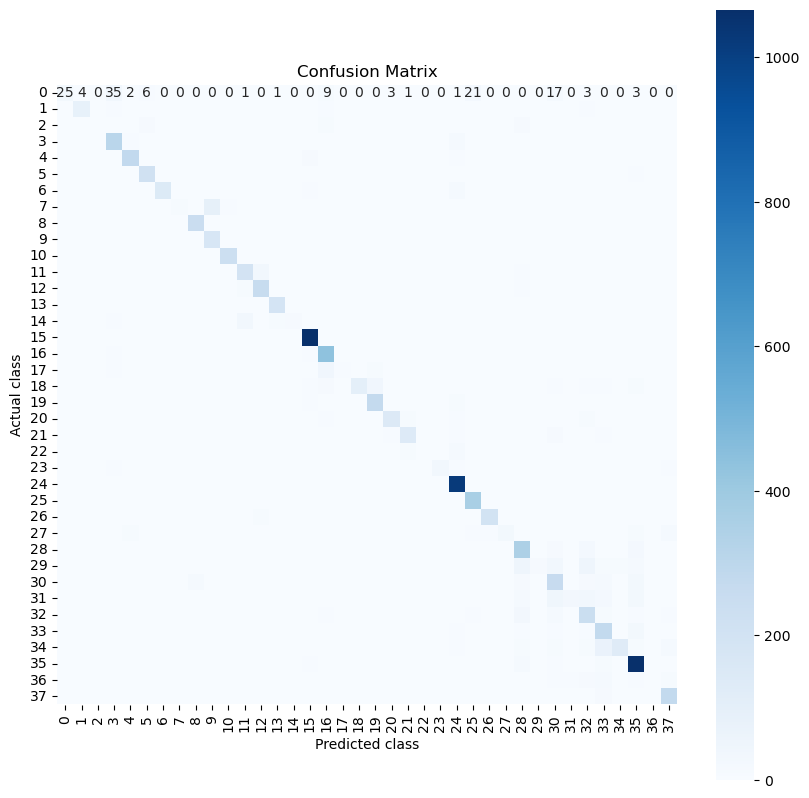

In [11]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
print(classification_report(all_labels, all_preds))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", square=True, cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model_path = "trained_googlenet.pth"

# Save the model
torch.save(model.state_dict(), model_path)